In [114]:
import numpy as np
from hankel import SymmetricFourierTransform

import matplotlib.pyplot as plt

In [115]:
hbarc = 0.2     # eV um
rho_T = 2.0e3   # Sphere density, kg/m^3
mAMU = 1.66e-27 # Neutron mass

In [116]:
R_um = 5          # Sphere radius, um
R = R_um / hbarc  # Radius in natural units, eV^-1

N_T = 0.5 * ( 4/3 * np.pi * (R_um*1e-6)**3) * rho_T/mAMU # Number of neutrons
res = 170e6       # detector resolution in eV

q_thr = 0.05e9    # momentum threshold, eV

In [117]:
M_X_in = 5e3         # GeV
alpha_n_in = 1e-8    # Gev
m_phi = 0.001        # Mediator mass, eV

In [118]:
M_X = M_X_in * 1e9    # Dark matter nugget mass, eV (assumes mass in GeV given on command line)
m_chi = 0.01 * 1e9    # eV
N_chi = M_X / m_chi   # Number of dark matter particles in the nugget

rhoDM = 0.3e9         # dark matter mass density, eV/cm^3
mR = m_phi * R        # (= R/lambda), a useful length scale; now defiend in `vtot()`

alpha_n = alpha_n_in  # Dimensionless single neutron-nugget coupling
alpha = alpha_n * N_T # Coupling of the entire sphere

In [119]:
vmin = 5e-5      # minimum velocity to consider, natural units (c)
vesc = 1.815e-3  # galactic escape velocity
v0 = 7.34e-4     # v0 parameter from Zurek group paper
ve = 8.172e-4    # ve parameter from Zurek group paper

In [120]:
nvels = 2000      # number of velocities to include in integration
vlist = np.linspace(vmin, vesc, nvels)

pmax = np.max((vesc * M_X, 10e9))
v = vlist[0]

p = M_X * v            # DM initial momentum (eV)
E = 1./2 * M_X * v**2  # Initial kinetic energy of incoming particle

In [45]:
theta = np.linspace(0, np.pi, 2000)
q = 2 * p * np.sin(theta / 2)
u = 1 / m_phi

In [46]:
dsig_domega = (4 * alpha**2 * M_X**2) / ((u**2 + q**2)**2)
dsig_dq = dsig_domega * 2 * np.pi * q / (p*p)

In [47]:
(4 * alpha**2 * M_X**2) / u**4

9.949037516622063e+26

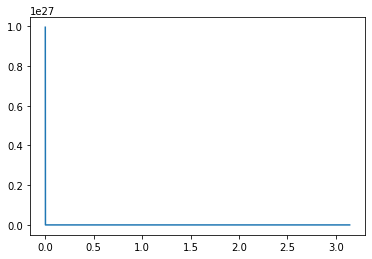

In [48]:
plt.plot(theta, dsig_domega)

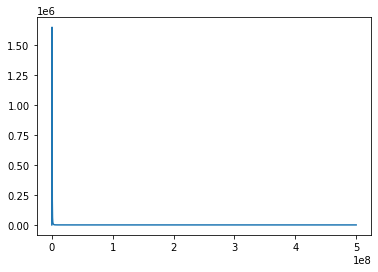

In [49]:
plt.plot(q, dsig_dq)

In [82]:
def vtot(u, m_phi, alpha):
    """Exact Yukawa potential for a uniform density sphere (vectorized version)
    
    Parameters
    ----------
    u : float, array-like
        Distance inverse 1/r in eV
    m_phi : float
        Mediator mass in eV
    alpha : float
        Dimensionless DM coupling to the sphere
        
    Returns
    -------
    float, array-like
        Potential V(u) for each u in eV
    """
    mR = m_phi * R
    
    u = np.asarray(u)
    ret = np.empty_like(u)
    
    # Devide the array of u=1/r into three cases
    neg     = (u <= 0)   # ill-defined
    outside = (u < 1/R)  # ouside sphere
    inside  = (u >= 1/R) # inside sphere
    
    ret[neg] = np.inf
    
    if(mR > 0):   # massive mediator
        ret[outside] = 3 * alpha/mR**3 * (mR * np.cosh(mR) - np.sinh(mR)) * np.exp(-m_phi/u[outside]) * u[outside]
        ret[inside] = 3 * alpha/mR**3 * (m_phi - u[inside]*(1 + mR)/(1+1./np.tanh(mR)) * (np.sinh(m_phi/u[inside])/np.sinh(mR)))
        
    else:         # massless mediator (alpha/r)
        ret[outside] = alpha * u[outside]
        ret[inside] = alpha/2 * (3/R - 1./(R**3 * u[inside]**2))

    return ret

Text(0, 0.5, 'v(r)')

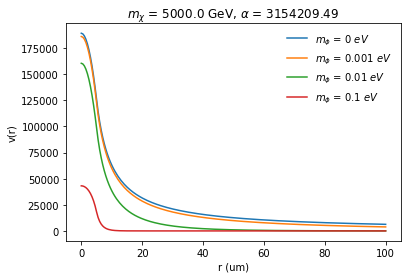

In [51]:
# Plotting the potential
r_um = np.linspace(1e-8, 100, 200)
r = r_um / hbarc # convert to eV

plt.plot(r_um, vtot(1/r, m_phi=0, alpha=alpha), label='$m_\phi$ = 0 $eV$')
plt.plot(r_um, vtot(1/r, m_phi=0.001, alpha=alpha), label='$m_\phi$ = 0.001 $eV$')
plt.plot(r_um, vtot(1/r, m_phi=0.01, alpha=alpha), label='$m_\phi$ = 0.01 $eV$')
plt.plot(r_um, vtot(1/r, m_phi=0.1, alpha=alpha), label='$m_\phi$ = 0.1 $eV$')

plt.title(fr'$m_\chi$ = {M_X_in} GeV, $\alpha$ = {alpha:.2f}')
plt.legend(frameon=False)
plt.xlabel('r (um)')
plt.ylabel('v(r)')

In [58]:
alpha = 5
mu = 0.0001

In [60]:
f = lambda r : alpha * np.exp(-1 * mu * r) * 1/r
k = np.logspace(-5, 7, 1000)

best_h, result, best_N = hankel.get_h(
    f = lambda r : alpha * np.exp(-1 * mu * r) * 1/r, nu=3,
    K= np.array([1e-5, 1e7]),
    cls=SymmetricFourierTransform
)
print(best_h, result, best_N)

0.003125 [6.22366515e+09 6.28321021e-13] 1005


In [61]:
ft = SymmetricFourierTransform(ndim=3, N=best_N, h=best_h)
Fk = ft.transform(f, k, ret_err=False)

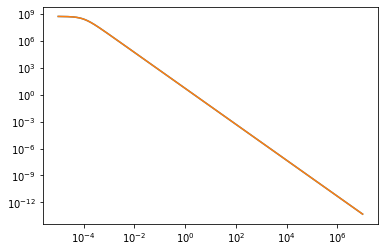

In [62]:
plt.loglog(k, Fk / (4*np.pi) )
plt.loglog(k, alpha / (mu**2 + k**2))

In [101]:
def vtot_func(u, m_phi, alpha):
    mR = m_phi * R
    
    if (u < 1/R):  # outside
        return 3 * alpha/mR**3 * (mR * np.cosh(mR) - np.sinh(mR)) * np.exp(-m_phi / u) * u
    else:          # inside
        return 3 * alpha/mR**3 * (m_phi - u * (1 + mR) / (1 + 1./np.tanh(mR)) * (np.sinh(m_phi/u) / np.sinh(mR)))

In [103]:
def f_yy(r):
    return vtot(u=1/r, m_phi=0.0001, alpha=alpha)

In [151]:
k = np.logspace(3, 10, 1000)

best_h, result, best_N = hankel.get_h(
    f=f_yy, 
    nu=3,
    K=np.array(k.min(), k.max()),
    cls=SymmetricFourierTransform
)
print(best_h, result, best_N)

0.05 -2.3858287743820394e-07 62


In [143]:
ft = SymmetricFourierTransform(ndim=3, N=best_N, h=best_h)
Fk = ft.transform(f_yy, k, ret_err=False)

In [144]:
dsig_domega = Fk * Fk * M_X * M_X / (4 * np.pi * np.pi)

In [145]:
dsig_dq = (2 * np.pi * k / (p*p) ) * dsig_domega

In [146]:
q_thr = 0.05e9 
dsig_dq[k < q_thr] = 0

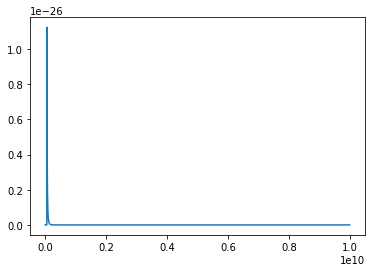

In [147]:
plt.plot(k, dsig_dq)

In [107]:
5 / hbarc

25.0